#### Data Loading: "Евгений Онегин" 

In [1]:
import string
import os
from random import sample
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
#Download .txt file containing Eugene Onegin novel  
with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()
text = [x.replace('\t\t', '') for x in text]

#### Text Preprocessing

In [4]:
text=(''.join(text)).lower() #Join all the strings into one and lowercase it
tokens = sorted(set(text)) + ['<sos>'] #Put all the characters, that you've seen in the text, into variable
num_tokens = len(tokens)
token_to_idx = {x: idx for idx, x in enumerate(tokens)} #Create dictionary token_to_idx = {<char>: <index>} 
idx_to_token = {idx: x for idx, x in enumerate(tokens)} #Create dictionary idx_to_token = {<index>: <char>}
text_encoded = [token_to_idx[x] for x in text]
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']
def generate_chunk(): #Random batch generation 
    global text_encoded, start_column, batch_size, seq_length
    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))

## Vanilla RNN model

#### Building the model

In [5]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, n_layers, drop_rate=0.2):
        super(RNNModel, self).__init__()
        #Initialize the model
        
        
        # Defining nn parameters
        self.hidden_dim = hidden_dim
        self.embedding_size = embedding_size
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        self.drop_rate = drop_rate
        self.char2int = None
        self.int2char = None


        #Defining the layers
        # Dropout layer
        self.dropout = nn.Dropout(drop_rate)
        # RNN Layer
        self.rnn = nn.RNN(embedding_size, hidden_dim, n_layers, batch_first = True)
        # Fully connected layer
        self.decoder = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, state):
        
        #Forward step of the RNNModel.
        rnn_out, state = self.rnn(x, state)
        rnn_out = self.dropout(rnn_out)  
        rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim)
         
        
       
        rnn_out, state = self.rnn(x, state)
        rnn_out = self.dropout(rnn_out)  
        rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim)

        logits = self.decoder(rnn_out)
        return logits, state

    def init_state(self, device, batch_size=1):
   #State Initialization
       
        return torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)

    def predict(self, input):
    #Predictions with the model
        logits, hidden = self.forward(input)
       
        probs = F.softmax(logits)
       
        probs = probs.view(input.size(0), input.size(1), probs.size(1))
        
       
        
       
        return probs, hidden

In [6]:
def one_hot_encode(indices, dict_size):
    ''' Define one hot encode matrix for our sequences'''
    
    features = np.eye(dict_size, dtype=np.float32)[indices.flatten()]
    
    features = features.reshape((*indices.shape, dict_size))
    
    return features

In [7]:
def train_main(model, optimizer, loss_fn, num_batches, val_batches, batch_size, seq_len, n_epochs, clip_norm, device):
    
    train_losses = []
    for epoch in range(1, n_epochs + 1):
    # Store the loss in every batch iteration
        epoch_losses = []
    # Initialize the hidden state for the current epoch
        hidden = model.init_state(device, batch_size)
    # Train on all the batches in the training dataset
        for i in range(num_batches-val_batches):
            # Get the next batch of data
            batch = next(generate_chunk())
            input_data = torch.from_numpy(one_hot_encode(batch[:, :-1], model.vocab_size))
            target_data = torch.from_numpy(batch[:, 1:])
            # Move input and target data to the device
            input_data = input_data.to(device)
            model.train()
            optimizer.zero_grad() # Clears existing gradients from previous epoch
            # Pass input data through the model
            hidden = Variable(hidden.data)
            output, hidden = model(input_data, hidden)
           
            output = output.to(device)
           
            target_data = target_data.to(device).long()
           
            target_data = torch.reshape(target_data, (batch_size*seq_len,))
            # Calculate the loss 
            loss = loss_fn(output, target_data.view(batch_size*seq_len))
          
            epoch_losses.append(loss.item()) 
             # Backpropagation
            loss.backward() 
            nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

            optimizer.step()

       # Evaluate the model on validation data
        model.eval()
        val_hidden = model.init_state(device, batch_size)
        val_losses = []
        for i in range(val_batches):
          
            batch = next(generate_chunk())
            input_data = torch.from_numpy(one_hot_encode(batch[:, :-1], model.vocab_size))
            target_data = torch.from_numpy(batch[:, 1:])
           
            input_data = input_data.to(device)
           
            hidden = Variable(hidden.data)
            output, hidden = model(input_data, hidden)
           
            output = output.to(device)
            
            target_data = target_data.to(device).long()
            
            target_data = torch.reshape(target_data, (batch_size*seq_len,))
            
            loss = loss_fn(output, target_data.view(batch_size*seq_len))
           
            val_losses.append(loss.item())

        model.train()
        # Print epoch information
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Train Loss: {:.4f}".format(np.mean(epoch_losses)), end=' ')
        print("Val Loss: {:.4f}".format(np.mean(val_losses)))
        train_losses.append(np.mean(epoch_losses))

    return train_losses

In [8]:
def set_device():
    is_cuda = torch.cuda.is_available()
    if is_cuda:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

In [9]:
#Hyperparameters
n_epochs = 200 #Was not enough time for training
lr=0.01
batch_size=batch_size
maxlen=seq_length
clip_norm=5
val_fraction = 0.1
hidden_dim = 128
n_layers = 1
embedding_size=num_tokens
dict_size = len(token_to_idx)
drop_rate = 0.2
# Set the device 
device = set_device()
seed = 1
torch.manual_seed(seed)
#Model
model = RNNModel(dict_size,embedding_size, hidden_dim, n_layers)
model = model.to(device)
#Loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#### Running the model

In [10]:
num_batches = 35 #Was not enough time for training
val_batches = 10 #Was not enough time for training
losses = train_main(model, optimizer, criterion, num_batches, val_batches, batch_size,
                    maxlen, n_epochs, clip_norm, device)

Epoch: 1/200............. Train Loss: 3.3329 Val Loss: 2.9602
Epoch: 2/200............. Train Loss: 2.7920 Val Loss: 2.6274
Epoch: 3/200............. Train Loss: 2.6085 Val Loss: 2.5152
Epoch: 4/200............. Train Loss: 2.5135 Val Loss: 2.4502
Epoch: 5/200............. Train Loss: 2.4643 Val Loss: 2.4223
Epoch: 6/200............. Train Loss: 2.4503 Val Loss: 2.3826
Epoch: 7/200............. Train Loss: 2.4139 Val Loss: 2.3528
Epoch: 8/200............. Train Loss: 2.3851 Val Loss: 2.3093
Epoch: 9/200............. Train Loss: 2.3680 Val Loss: 2.2840
Epoch: 10/200............. Train Loss: 2.3599 Val Loss: 2.2696
Epoch: 11/200............. Train Loss: 2.3332 Val Loss: 2.2476
Epoch: 12/200............. Train Loss: 2.3506 Val Loss: 2.2514
Epoch: 13/200............. Train Loss: 2.3017 Val Loss: 2.2303
Epoch: 14/200............. Train Loss: 2.2831 Val Loss: 2.1977
Epoch: 15/200............. Train Loss: 2.2680 Val Loss: 2.1688
Epoch: 16/200............. Train Loss: 2.2523 Val Loss: 2.1761
E

#### Loss Function

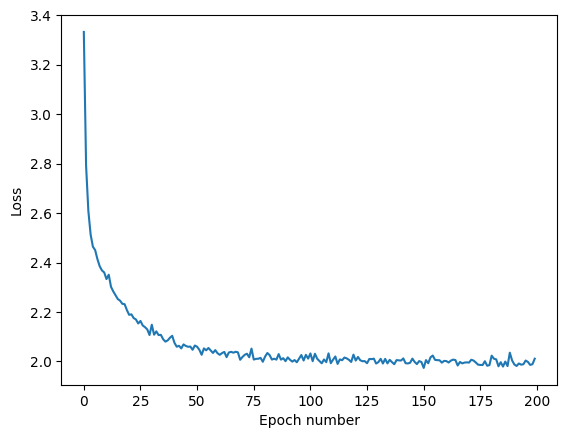

In [11]:
plt.plot(losses)
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.show()

#### Generated Text Example

In [12]:
def sample_from_probs(probs, top_n=10):
    """
    truncated weighted random choice.
    """
    _, indices = torch.sort(probs)
    probs[indices.data[:-top_n]] = 0
    
    sampled_index = torch.multinomial(probs, 1)
    return sampled_index

def predict_probs(model, hidden, character, temperature=1.0):
    
    if character == "<sos>":
      character = np.array([[token_to_idx[character]]])
    else:
      character = np.array([[token_to_idx[c] for c in character]])
  
    character = one_hot_encode(character, model.vocab_size)
    character = torch.from_numpy(character)
    character = character.to(device)

    out, hidden = model(character, hidden)

    logits = out[-1] / temperature
    prob = nn.functional.softmax(logits, dim=0).data

    return prob, hidden

In [13]:
def generate_sample(model, out_len, top_n=1, temperature=1.0, start='hey'):
    model.eval() # eval mode
    start = start.lower()
   
    chars = ["<sos>"] + [ch for ch in start]
    
    size = out_len - (len(chars) - 1)
    
    device = set_device()
    state = model.init_state(device, 1)

   
    for ch in chars:
       
        probs, state = predict_probs(model, state, ch, temperature)
        next_index = sample_from_probs(probs, top_n)

    
    for ii in range(size):
        
        probs, state = predict_probs(model, state, chars, temperature)
        next_index = sample_from_probs(probs, top_n)
       
        chars.append(idx_to_token[int(next_index.data[0])])

    return ''.join(chars)

In [15]:
text_predicted = generate_sample(model, 500, 3, 1.0, 'Пацаны вообще ребята')
print(text_predicted)
print(len(text_predicted))

<sos>пацаны вообще ребята,
и скарасти совертья,
посталой вотрод саводала,
как постало в том она пристало он страснной востой
карать,
и сторой столовая всехорись,
и всё в поле свой свето
на приченатьсен передеет
пред настоки молети пределин,
не сте презрокнет никань
издаляс о вет она толья,
и всё, что приколодит,
подобрый семительный поле
на строго в сердце, волковенной порадетний подала
сердца света
пред намо простотой
он старика он порогоный,
тетве пред него дево, конет и вотрона,
и в сердца он печа
505


## LSTM Model

Basically, almost nothing is changed if we switch to LSTM architecture. We add the cell state and slightly change the train_main function.

#### Building the model

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, n_layers, drop_rate=0.2):
        
        super(LSTMModel, self).__init__()

        # Defining nn parameters
        self.hidden_dim = hidden_dim
        self.embedding_size = embedding_size
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        self.drop_rate = drop_rate
        self.char2int = None
        self.int2char = None


        #Defining the layers
        self.dropout = nn.Dropout(drop_rate)
        self.rnn = nn.LSTM(embedding_size, hidden_dim, n_layers, dropout=drop_rate, batch_first = True)
        self.decoder = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, state):
        #Forward step
        rnn_out, state = self.rnn(x, state)
        rnn_out = self.dropout(rnn_out)
        rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim)
        logits = self.decoder(rnn_out)
        return logits, state
    
    def init_state(self, device, batch_size=1):
        #Cell state is added
       
        return (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device))

    def predict(self, input):
       #Model prediction
        logits, hidden = self.forward(input)
        
        probs = F.softmax(logits)
        
        probs = probs.view(input.size(0), input.size(1), probs.size(1))
        
        return probs, hidden

In [17]:
def train_main_lstm(model, optimizer, loss_fn, num_batches, val_batches, batch_size, seq_len, n_epochs, clip_norm, device):
    #Almost same with the previous case
    for epoch in range(1, n_epochs + 1):
        epoch_losses = []
        hidden = model.init_state(device, batch_size)
        for i in range(num_batches-val_batches):
            batch = next(generate_chunk())
            input_data = torch.from_numpy(one_hot_encode(batch[:, :-1], model.vocab_size))
            target_data = torch.from_numpy(batch[:, 1:])
            input_data = input_data.to(device)
            model.train()
            optimizer.zero_grad() # Clears existing gradients from previous epoch
            hidden = tuple(([Variable(var.data) for var in hidden]))
            output, hidden = model(input_data, hidden)
            output = output.to(device)
            target_data = target_data.to(device).long()
            target_data = torch.reshape(target_data, (batch_size*seq_len,))
            loss = loss_fn(output, target_data.view(batch_size*seq_len))
            epoch_losses.append(loss.item()) #data[0]
            loss.backward() # Does backpropagation and calculates gradients
            nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            optimizer.step() # Updates the weights accordingly
        #Evaluation
        model.eval()
        val_hidden = model.init_state(device, batch_size)
        val_losses = []
        for i in range(val_batches):
            batch = next(generate_chunk())
            input_data = torch.from_numpy(one_hot_encode(batch[:, :-1], model.vocab_size))
            target_data = torch.from_numpy(batch[:, 1:])
            input_data = input_data.to(device)
            hidden = tuple(([Variable(var.data) for var in hidden]))
            output, hidden = model(input_data, hidden)
            output = output.to(device)
            target_data = target_data.to(device).long()
            target_data = torch.reshape(target_data, (batch_size*seq_len,))
            loss = loss_fn(output, target_data.view(batch_size*seq_len))
            val_losses.append(loss.item()) 

        model.train()                  
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Train Loss: {:.4f}".format(np.mean(epoch_losses)), end=' ')
        print("Val Loss: {:.4f}".format(np.mean(val_losses)))
        
    return epoch_losses

In [18]:
#Hyperparameters
n_epochs = 200 #Was not enough time for training 
lr=0.01
batch_size=batch_size
maxlen=seq_length
clip_norm=5
val_fraction = 0.1
hidden_dim = 128
n_layers = 1
embedding_size=num_tokens
dict_size = len(token_to_idx)
drop_rate = 0.2
# Set the device 
device = set_device()
seed = 1
torch.manual_seed(seed)
#Model
model = RNNModel(dict_size,embedding_size, hidden_dim, n_layers)
model = model.to(device)
#Loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [19]:
#Model
model_lstm = LSTMModel(dict_size,embedding_size, hidden_dim, n_layers)
model_lstm = model_lstm.to(device)
#Loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=lr)

C:\Users\Andrei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


#### Running the model

In [20]:
num_batches = 50 #Was not enough time for training
val_batches = 15 #Was not enough time for training
losses = train_main_lstm(model_lstm, optimizer, criterion, num_batches, val_batches, batch_size,
                    maxlen, n_epochs, clip_norm, device)

Epoch: 1/200............. Train Loss: 3.3478 Val Loss: 3.0513
Epoch: 2/200............. Train Loss: 2.8045 Val Loss: 2.5937
Epoch: 3/200............. Train Loss: 2.5703 Val Loss: 2.4616
Epoch: 4/200............. Train Loss: 2.4690 Val Loss: 2.3831
Epoch: 5/200............. Train Loss: 2.3859 Val Loss: 2.2829
Epoch: 6/200............. Train Loss: 2.2957 Val Loss: 2.2012
Epoch: 7/200............. Train Loss: 2.2300 Val Loss: 2.1371
Epoch: 8/200............. Train Loss: 2.1791 Val Loss: 2.0759
Epoch: 9/200............. Train Loss: 2.1390 Val Loss: 2.0298
Epoch: 10/200............. Train Loss: 2.0906 Val Loss: 2.0013
Epoch: 11/200............. Train Loss: 2.0511 Val Loss: 1.9594
Epoch: 12/200............. Train Loss: 2.0170 Val Loss: 1.9084
Epoch: 13/200............. Train Loss: 1.9860 Val Loss: 1.8940
Epoch: 14/200............. Train Loss: 1.9665 Val Loss: 1.8755
Epoch: 15/200............. Train Loss: 1.9404 Val Loss: 1.8406
Epoch: 16/200............. Train Loss: 1.9132 Val Loss: 1.8042
E

In [33]:
losses=[3.34,2.80,2.57,2.46,2.38,2.29,2.23,2.17,2.13,2.09,2.05,2.01,1.98,1.96,1.94,1.91,1.89,1.88,1.86,1.83,1.83,1.82,1.8,1.78,1.77,1.75,1.74,1.75,1.72,1.74,1.72,1.69,1.68,1.67,1.66,1.68,1.65,1.65,1.63,1.66,1.65,1.63,1.60,1.63,1.62,1.63,1.60,1.63,1.61,1.62,1.61,1.63,1.62,1.61,1.59,1.60,1.58,1.60,1.58,1.58,1.58,1.58,1.57,1.58,1.56,1.58,1.56,1.58,1.56,1.57,1.56,1.56,1.57,1.55,1.53,1.56,1.55,1.54,1.53,1.56,1.55,1.54,1.52,1.52,1.54,1.54,1.54,1.54,1.53,1.53,1.52,1.54,1.51,1.52,1.53,1.53,1.52,1.52,1.52,1.52,1.50,1.51,1.52,1.51,1.50,1.53,1.52,1.49,1.52,1.53,1.52,1.51,1.50,1.48,1.51,1.52,1.51,1.52,1.51,1.49,1.48,1.5,1.51,1.5,1.49,1.51,1.5,1.49,1.52,1.5,1.5,1.5,1.52,1.51,1.48,1.5,1.5,1.49,1.49,1.52,1.48,1.48,1.51,1.51,1.5,1.5,1.49,1.51,1.51,1.47,1.49,1.49,1.48,1.49,1.5,1.48,1.5,1.5,1.49,1.48,1.48,1.46,1.49,1.47,1.46,1.49,1.49,1.52,1.49,1.49,1.47,1.47,1.48,1.47,1.5,1.5,1.47,1.47,1.47,1.5,1.5,1.47,1.49,1.52,1.51,1.49,1.49,1.49,1.46,1.47,1.48,1.47,1.5,1.51,1.5,1.49,1.48,1.48,1.49,1.44]

#### Loss function

200


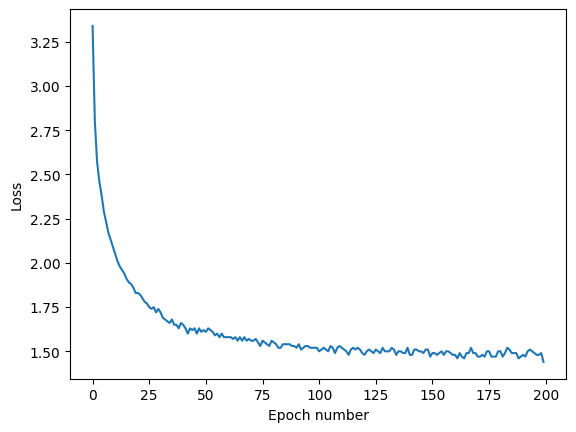

In [34]:
plt.plot(losses)
print(len(losses))
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.show()

#### Generated Text Example

In [24]:
text_predicted = generate_sample(model_lstm, 500, 3, 1.0, 'Ребята')
print(text_predicted)
print(len(text_predicted))

<sos>ребята,
в конечне, клатей одно,
всё то было страшели в небо взоль,
она в сердце простать и молчал
встаре, в гранной резкий, и глушь!
и все воз водо сердечно
всё то же быль на постептым оброды,
со други всех сердце своей
светил болчал и свет онеганий,
подсуженной послушинесь,
и в темного приветной
встречаешь томный вас одна,
и все продличиванных затей
не правда все простой призрасья
уселит недострохом простимей
прости, и сердцем им не сказался,
откромна, слеза перед ней;
на селовый в темного кний
505


## Save the model

In [48]:
model_info_path = os.path.join('C:\AI_Basics', 'model_info.pth')
with open(model_info_path, 'wb') as f:
    model_info = {
        'n_layers': n_layers,
        'embedding_dim': embedding_size,
        'hidden_dim': hidden_dim,
        'vocab_size': dict_size,
        'drop_rate': drop_rate
    }
    torch.save(model_info, f)

# Save the model parameters
model_path = os.path.join('C:\AI_Basics', 'model.pth')
with open(model_path, 'wb') as f:
    torch.save(model.state_dict(), f)

In [ ]:
model_info_path = os.path.join('C:\AI_Basics', 'model_info.pth')
with open(model_info_path, 'wb') as f:
    model_info = {
        'n_layers': n_layers,
        'embedding_dim': embedding_size,
        'hidden_dim': hidden_dim,
        'vocab_size': dict_size,
        'drop_rate': drop_rate
    }
    torch.save(model_info, f)

# Save the model parameters
model_path = os.path.join('C:\AI_Basics', 'model.pth')
with open(model_path, 'wb') as f:
    torch.save(model_lstm.state_dict(), f)